In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from scipy.signal import find_peaks

20000.0


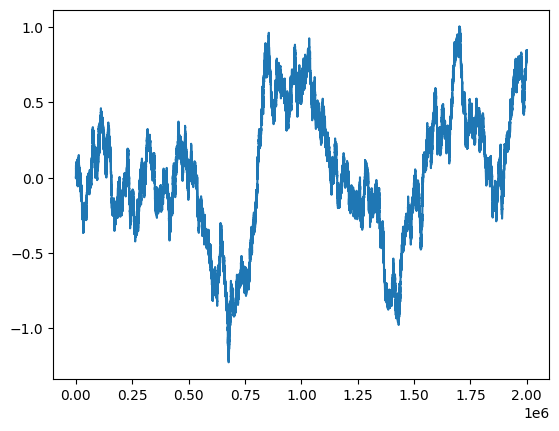

In [2]:
sampling_rate=2*1e6
sample_time=1/sampling_rate
N=2000000
def ou_noise(n, dt=1.0, mu=0.0, tau=20.0, sigma=1.0, x0=0.0, rng=None):
    rng = np.random.default_rng(rng)
    x = np.empty(n)
    x[0] = x0
    a = np.exp(-dt / tau)
    sd = sigma * np.sqrt(1 - a*a)
    for t in range(1, n):
        x[t] = mu + a*(x[t-1] - mu) + sd * rng.normal()
    return x
#I am setting tau to be 50ms
x = ou_noise(N, dt=sample_time, tau=100*1e-3, sigma=0.5)
plt.plot(x)
print(10*1e-3/sample_time)

In [3]:
Channel_dict={}
num_channels=10
actual_coh_time={}
for i in range(10):
    tau_I=random.randint(1,25)
    tau_Q=random.randint(1,25)
    Channel_dict[i]={'I':ou_noise(N,dt=sample_time,tau=tau_I*1e-3,sigma=0.5),'Q':ou_noise(N,dt=sample_time,tau=tau_Q*1e-3,sigma=0.5)}
    actual_coh_time[i]={'I':tau_I*1e-3/sample_time,'Q':tau_Q*1e-3/sample_time}
print(actual_coh_time)

{0: {'I': 48000.0, 'Q': 2000.0000000000002}, 1: {'I': 24000.0, 'Q': 22000.0}, 2: {'I': 48000.0, 'Q': 50000.00000000001}, 3: {'I': 14000.000000000002, 'Q': 46000.0}, 4: {'I': 28000.000000000004, 'Q': 24000.0}, 5: {'I': 36000.00000000001, 'Q': 22000.0}, 6: {'I': 4000.0000000000005, 'Q': 28000.000000000004}, 7: {'I': 8000.000000000001, 'Q': 30000.0}, 8: {'I': 28000.000000000004, 'Q': 12000.0}, 9: {'I': 48000.0, 'Q': 22000.0}}


In [4]:
from numpy.fft import rfft, irfft

def autocorr_fft(x):
    x = np.asarray(x)
    x = x - x.mean()            # optional, improves robustness
    n = len(x)
    nfft = 1 << (2*n-1).bit_length()  # next pow2 for speed
    X = rfft(x, nfft)
    r = irfft(X * np.conj(X), nfft)[:n]   # non-negative lags
    r = r / (r[0] + 1e-20)      # normalize
    return r

def find_coh_time_fft(x, threshold=1e-2):
    r = autocorr_fft(x)
    # first lag where it drops below threshold
    idx = np.argmax(r <= threshold)  # returns 0 if first element meets
    if r[0] <= threshold:            # guard unlikely case
        return 0
    if idx == 0:                     # no drop found
        return len(r)                # cap at window length
    return idx

def find_coherence_time_per_channel(Wifi_symbol_dict):
    num_samples_per_coherence_detection=int(50*1e-3/sample_time) #We need 50ms data for this
    t_coh_dict={}
    for channel in Wifi_symbol_dict:
        t_coh_dict[channel]={'I':0,'Q':0}
        i=0
        number_samples=len(Wifi_symbol_dict[channel]['I'])
        t_coh_distribution_arr_I=[]
        t_coh_distribution_arr_Q=[]
        while num_samples_per_coherence_detection*i<number_samples:
            #normalised_I_samples=Wifi_symbol_dict[channel]['I']
            I_curr_samples=Wifi_symbol_dict[channel]['I'][i*num_samples_per_coherence_detection:(i+1)*num_samples_per_coherence_detection]
            Q_curr_samples=Wifi_symbol_dict[channel]['Q'][i*num_samples_per_coherence_detection:(i+1)*num_samples_per_coherence_detection]
            t_coh_distribution_arr_I.append(find_coh_time_fft(I_curr_samples))
            t_coh_distribution_arr_Q.append(find_coh_time_fft(Q_curr_samples))
            i+=1
            #print(i)
         #break
        t_coh_dict[channel]['I']=np.mean(t_coh_distribution_arr_I)
        t_coh_dict[channel]['Q']=np.mean(t_coh_distribution_arr_Q)
    
    return t_coh_dict


# #print(find_coh_time_fft(x[:100000]))
print(find_coherence_time_per_channel(Channel_dict))
dict_coherence_times = find_coherence_time_per_channel(Channel_dict)


{0: {'I': 22775.9, 'Q': 7435.3}, 1: {'I': 24827.5, 'Q': 21926.7}, 2: {'I': 22207.8, 'Q': 21490.45}, 3: {'I': 17181.65, 'Q': 19676.6}, 4: {'I': 23154.5, 'Q': 22631.75}, 5: {'I': 19981.6, 'Q': 18286.95}, 6: {'I': 13040.9, 'Q': 19652.9}, 7: {'I': 13810.95, 'Q': 21473.95}, 8: {'I': 23274.25, 'Q': 16329.8}, 9: {'I': 22011.05, 'Q': 19911.75}}


In [5]:
print(Channel_dict)

{0: {'I': array([ 0.        , -0.00184092, -0.00381939, ..., -0.01549431,
       -0.01850444, -0.01917719]), 'Q': array([ 0.        , -0.00570458, -0.00554957, ..., -0.32974304,
       -0.33285499, -0.30192323])}, 1: {'I': array([0.        , 0.00320847, 0.00736098, ..., 0.10161046, 0.09524955,
       0.0872467 ]), 'Q': array([0.        , 0.00464343, 0.00478766, ..., 0.71675532, 0.71597273,
       0.71717576])}, 2: {'I': array([ 0.        ,  0.00092753,  0.00251267, ..., -0.83206162,
       -0.83372923, -0.83055141]), 'Q': array([ 0.        , -0.0023035 , -0.00189719, ..., -0.78955965,
       -0.78856448, -0.78992496])}, 3: {'I': array([ 0.        , -0.00752495,  0.00202623, ..., -0.32302556,
       -0.32400132, -0.33165801]), 'Q': array([ 0.        ,  0.00690164,  0.0102984 , ..., -0.10996456,
       -0.11386009, -0.11324653])}, 4: {'I': array([ 0.        , -0.00021392, -0.00566116, ..., -0.10984882,
       -0.10606082, -0.10609663]), 'Q': array([ 0.        , -0.00579819, -0.00600208, 

In [6]:
# multi armed bandit to select next channel to scan
int(50*1e-3/sample_time)

100000

In [7]:
# each channel is one arm
num_channels = 10 # number of arms

arm_coherent_time = {}
arm_dwell_time = {}

arms_with_reward = {}
arm_last_played_time = {}
arm_coherent_time = {}

for i in range(num_channels):
    arms_with_reward[i] = 0
    arm_last_played_time[i] = 0
    arm_coherent_time[i] = min(dict_coherence_times[i]['I'], dict_coherence_times[i]['Q'])
    #arm_coherent_time[i] = random.randint(400, 1000)
    arm_dwell_time[i] = int(1e8 / arm_coherent_time[i]) # seems correct


In [88]:
# print(Channel_dict)
# print(len(Channel_dict))
# print(Channel_dict[9])
# print(len(Channel_dict[9]['I']))
# print(arm_coherent_time[1])

In [8]:
def get_reward(channel_chosen, current_sample_index, arm_last_played_time, arm_coherent_time):
    reward = (current_sample_index - arm_last_played_time[channel_chosen])/arm_coherent_time[channel_chosen]
    return (reward)

In [9]:
def selected_arm(epsilon):
    k = random.random()
    if (k < epsilon) : 
        next_arm = random.randint(0, num_channels-1)
    else:
        next_arm = max(arms_with_reward, key = arms_with_reward.get)
    return(next_arm)

# def selected_arm():
#     next_arm = max(arms_with_reward, key = arms_with_reward.get)
#     return(next_arm)

In [10]:
Wifi_output_samples={}
temp_output_samples = {}
for channel in Channel_dict:
    Wifi_output_samples[channel]={'I':[],'Q':[]}  # storing in the form of a list of elements (sample_num,value) for I and Q
epsilon = 0.5
# epsilon_decay = 0.995
total_samples = 2000000

current_sample_index = 0
while(current_sample_index<total_samples):

    temp_output_samples = {}

    for i in range(num_channels):
        arms_with_reward[i] = get_reward(i, current_sample_index, arm_last_played_time, arm_coherent_time)
    next_arm = selected_arm(epsilon)
    temp_output_samples[next_arm] = {}
    temp_output_samples[next_arm]['I'] = []
    temp_output_samples[next_arm]['Q'] = []
    arms_with_reward[next_arm] = 0
    for i in range(arm_dwell_time[next_arm]):
        if current_sample_index==total_samples-1:
            current_sample_index+=1
            break
        Wifi_output_samples[next_arm]['I'].append([current_sample_index, Channel_dict[next_arm]['I'][current_sample_index]])
        Wifi_output_samples[next_arm]['Q'].append([current_sample_index, Channel_dict[next_arm]['Q'][current_sample_index]])
        temp_output_samples[next_arm]['I'].append(Channel_dict[next_arm]['I'][current_sample_index])
        temp_output_samples[next_arm]['Q'].append(Channel_dict[next_arm]['Q'][current_sample_index])
        current_sample_index+=1   

    # print(temp_output_samples)

    coh_time_to_update = find_coherence_time_per_channel(temp_output_samples)
    arm_coherent_time[next_arm] = min(coh_time_to_update[next_arm]['I'], coh_time_to_update[next_arm]['Q'])
    arm_dwell_time[next_arm] = int(1e8 / arm_coherent_time[next_arm]) # seems correct


    arm_last_played_time[next_arm] = current_sample_index

In [11]:
#print(arm_stddev)
#print(arm_mean_time)
for i in range(num_channels):
    print(Wifi_output_samples[i]['I'][:100])

[[0, 0.0], [1, -0.001840920444536845], [2, -0.003819392871880012], [3, -0.0025939137276104157], [4, 0.0017801779699792488], [5, -0.003666640361107645], [6, -0.004211727214164449], [7, 0.0011960635472499977], [8, 0.0013020473605029894], [9, -0.001798068467446089], [10, 0.002519645014771698], [11, 0.0005699796492034232], [12, -0.002403297161553855], [13, -0.004459424246729401], [14, -0.006069001486279732], [15, -0.010362458707995667], [16, -0.013552248771162456], [17, -0.0129858874961779], [18, -0.013260823811377652], [19, -0.0142191326544152], [20, -0.013322925165148247], [21, -0.010054799392025155], [22, -0.0077522933214118454], [23, -0.0036644709666922093], [24, -0.004710659564803336], [25, -0.006483006441685223], [26, -0.009844587646375292], [27, -0.013704255555229356], [28, -0.012730089975660368], [29, -0.01672693935003294], [30, -0.013003123194844554], [31, -0.012477572883703525], [32, -0.014377930561757688], [33, -0.01557758326837747], [34, -0.016286676982426584], [35, -0.01910026

In [12]:
print(arm_last_played_time)

{0: 1532554, 1: 1959297, 2: 1754748, 3: 1434530, 4: 1647860, 5: 1379156, 6: 1407206, 7: 1789518, 8: 1664739, 9: 2000000}


In [13]:
print((arm_dwell_time))

{0: 24437, 1: 8311, 2: 7275, 3: 23014, 4: 33145, 5: 64977, 6: 23004, 7: 25012, 8: 53590, 9: 14556}


In [14]:
print(arm_coherent_time)

{0: 4092.0, 1: 12031.5, 2: 13744.0, 3: 4345.0, 4: 3017.0, 5: 1539.0, 6: 4347.0, 7: 3998.0, 8: 1866.0, 9: 6870.0}


In [15]:
print(max(arm_dwell_time))
print(arm_dwell_time[9])

9
14556


In [21]:
def get_sampled_channel(data,total_num_samples):
    "The input data is of the form [index,value] we need to be able to diffrentiate between periodic and non periodic signals to do this we are just linearly interpolating in stft"
    output_wifi_samples={}
    for channel in data:
        
        output_wifi_samples[channel]={'I':np.array([0 for i in range(total_num_samples)]),'Q':np.array([0 for i in range(total_num_samples)])}
        I = np.zeros(total_num_samples, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['I']:
            idx = int(cur_sample)
            I[idx] = float(val)
        output_wifi_samples[channel]['I'] = I  # ensure the mutated array is stored
        Q = np.zeros(total_num_samples, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['Q']:
            idx = int(cur_sample)
            Q[idx] = float(val)
        output_wifi_samples[channel]['Q'] = Q  # ensure the mutated array is stored

    return output_wifi_samples

output_samples_for_each_channel=get_sampled_channel(Wifi_output_samples,2000000)

In [22]:
print(output_samples_for_each_channel)

{0: {'I': array([ 0.        , -0.00184092, -0.00381939, ...,  0.        ,
        0.        ,  0.        ]), 'Q': array([ 0.        , -0.00570458, -0.00554957, ...,  0.        ,
        0.        ,  0.        ])}, 1: {'I': array([0., 0., 0., ..., 0., 0., 0.]), 'Q': array([0., 0., 0., ..., 0., 0., 0.])}, 2: {'I': array([0., 0., 0., ..., 0., 0., 0.]), 'Q': array([0., 0., 0., ..., 0., 0., 0.])}, 3: {'I': array([0., 0., 0., ..., 0., 0., 0.]), 'Q': array([0., 0., 0., ..., 0., 0., 0.])}, 4: {'I': array([0., 0., 0., ..., 0., 0., 0.]), 'Q': array([0., 0., 0., ..., 0., 0., 0.])}, 5: {'I': array([0., 0., 0., ..., 0., 0., 0.]), 'Q': array([0., 0., 0., ..., 0., 0., 0.])}, 6: {'I': array([0., 0., 0., ..., 0., 0., 0.]), 'Q': array([0., 0., 0., ..., 0., 0., 0.])}, 7: {'I': array([0., 0., 0., ..., 0., 0., 0.]), 'Q': array([0., 0., 0., ..., 0., 0., 0.])}, 8: {'I': array([0., 0., 0., ..., 0., 0., 0.]), 'Q': array([0., 0., 0., ..., 0., 0., 0.])}, 9: {'I': array([ 0.        ,  0.        ,  0.        , ...

Naive Signal:

In [ ]:
Wifi_naive_symbols={}
size_of_naive_samples_per_channel=100000

cur_num=0
for channel in Channel_dict:
    Wifi_naive_symbols[channel]={'I':[],'Q':[]}

while cur_num<total_samples:
    for channel in Channel_dict:
        for i in range(size_of_naive_samples_per_channel):
            Wifi_naive_symbols[channel]['I'].append((cur_num,Channel_dict[channel]['I'][cur_num]))
            Wifi_naive_symbols[channel]['Q'].append((cur_num,Channel_dict[channel]['Q'][cur_num]))
            cur_num+=1
        #cur_num+=size_of_naive_samples_per_channel
        if cur_num>=total_samples:
            break
#I = np.zeros(2_000_000, dtype=np.float64)  # force float64
print(Wifi_naive_symbols[1]['I'][:100])
#Wifi_naive_symbols[channel]['I'] = I  # ensure the mutated array is stored


[(100000, -1.129568779052213), (100001, -1.1429358758073804), (100002, -1.1393619389824368), (100003, -1.1402735519713596), (100004, -1.1418150463185075), (100005, -1.1409846044123118), (100006, -1.1420486281480287), (100007, -1.1449551420558766), (100008, -1.1383148493836037), (100009, -1.1451321638491363), (100010, -1.1421538491390297), (100011, -1.1470567600326973), (100012, -1.1465627024029932), (100013, -1.1426198433009773), (100014, -1.1430639732461871), (100015, -1.14313042560722), (100016, -1.1470043717595182), (100017, -1.148461283738284), (100018, -1.145895575424277), (100019, -1.1496235776655261), (100020, -1.149475469837943), (100021, -1.1496692362247032), (100022, -1.1624831078654152), (100023, -1.1605022716847466), (100024, -1.160547272224221), (100025, -1.1620814338335006), (100026, -1.1670205233365571), (100027, -1.167435616407682), (100028, -1.1611242492052565), (100029, -1.164723054520545), (100030, -1.1621313393488417), (100031, -1.1572609099516493), (100032, -1.1569

In [33]:
output_samples_for_each_channel_naive=get_sampled_channel(Wifi_naive_symbols, 2000000)

In [23]:
def finding_power(output_samples_for_each_channel, sample_time, num_channels, total_samples):
    """
    Compute per-channel power in fixed-size sample blocks and fill zeros
    between nonzero stretches with the average power of the previous stretch.

    Returns:
        power_per_channel: {
            channel_index: {
                'I': np.ndarray of shape (total_samples,),
                'Q': np.ndarray of shape (total_samples,)
            }
        }
    """
    sampleblock_length = int((0.5 / sample_time) // 10)
    power_per_channel = {}

    for i in range(num_channels):
        I_signal = np.array(output_samples_for_each_channel[i]['I'])
        Q_signal = np.array(output_samples_for_each_channel[i]['Q'])

        power_I = np.zeros(total_samples)
        power_Q = np.zeros(total_samples)

        nonzero_mask = (I_signal != 0) | (Q_signal != 0)
        diff_mask = np.diff(nonzero_mask.astype(int))
        starts = np.where(diff_mask == 1)[0] + 1  # rising edges
        ends = np.where(diff_mask == -1)[0] + 1   # falling edges

        # handle cases where signal starts or ends as nonzero
        if nonzero_mask[0]:
            starts = np.insert(starts, 0, 0)
        if nonzero_mask[-1]:
            ends = np.append(ends, total_samples)

        prev_end = 0
        avg_power_I = 0
        avg_power_Q = 0

        for s, e in zip(starts, ends):
            stretch_len = e - s
            n_blocks = int(np.ceil(stretch_len / sampleblock_length))

            block_powers_I = []
            block_powers_Q = []

            for b in range(n_blocks):
                start_idx = s + b * sampleblock_length
                end_idx = min(s + (b + 1) * sampleblock_length, e)

                I_block = I_signal[start_idx:end_idx]
                Q_block = Q_signal[start_idx:end_idx]

                block_power_I = np.mean(I_block**2)
                block_power_Q = np.mean(Q_block**2)

                power_I[start_idx:end_idx] = block_power_I
                power_Q[start_idx:end_idx] = block_power_Q

                block_powers_I.append(block_power_I)
                block_powers_Q.append(block_power_Q)

            avg_power_I = np.mean(block_powers_I)
            avg_power_Q = np.mean(block_powers_Q)

            # fill zeros before this stretch with average power from current stretch
            if prev_end < s:
                power_I[prev_end:s] = avg_power_I
                power_Q[prev_end:s] = avg_power_Q

            prev_end = e

        # fill tail after last stretch
        if prev_end < total_samples:
            power_I[prev_end:] = avg_power_I
            power_Q[prev_end:] = avg_power_Q

        power_per_channel[i] = {'I': power_I, 'Q': power_Q}

    return power_per_channel

In [40]:
sample_time = 1/(2*1e4)

result = finding_power(output_samples_for_each_channel, sample_time, num_channels, total_samples)

print("Channel 0 Power (first 20 samples):")
print(result[0]['I'][:20])

result_naive = finding_power(output_samples_for_each_channel_naive, sample_time, num_channels, total_samples)

print("Channel 0 Power (first 20 samples):")
print(result_naive[0]['I'][:20])

result_ground_truth = finding_power(Channel_dict, sample_time, num_channels, total_samples)


Channel 0 Power (first 20 samples):
[0.01270033 0.00072228 0.00072228 0.00072228 0.00072228 0.00072228
 0.00072228 0.00072228 0.00072228 0.00072228 0.00072228 0.00072228
 0.00072228 0.00072228 0.00072228 0.00072228 0.00072228 0.00072228
 0.00072228 0.00072228]
Channel 0 Power (first 20 samples):
[0.16439133 0.00072228 0.00072228 0.00072228 0.00072228 0.00072228
 0.00072228 0.00072228 0.00072228 0.00072228 0.00072228 0.00072228
 0.00072228 0.00072228 0.00072228 0.00072228 0.00072228 0.00072228
 0.00072228 0.00072228]


In [25]:
def plot_power_and_signals(output_samples_for_each_channel, power_per_channel, num_channels_1):
    """
    Plot I/Q signals and their computed power for each channel.
    """
    fig, axs = plt.subplots(num_channels_1, 2, figsize=(12, 6), sharex=True)

    for i in range(num_channels_1):
        # Extract data
        I_signal = np.array(output_samples_for_each_channel[i]['I'])
        Q_signal = np.array(output_samples_for_each_channel[i]['Q'])
        power_I = power_per_channel[i]['I']
        power_Q = power_per_channel[i]['Q']
        samples = np.arange(len(I_signal))

        # --- I component ---
        axs[i, 0].plot(samples, I_signal, label="I signal", color='steelblue', alpha=0.7)
        axs[i, 0].plot(samples, power_I, label="I power", color='crimson', linestyle='--', linewidth=2)
        axs[i, 0].set_title(f"Channel {i} - I Component")
        axs[i, 0].set_ylabel("Amplitude / Power")
        axs[i, 0].legend()
        axs[i, 0].grid(True, linestyle='--', alpha=0.4)

        # --- Q component ---
        axs[i, 1].plot(samples, Q_signal, label="Q signal", color='darkgreen', alpha=0.7)
        axs[i, 1].plot(samples, power_Q, label="Q power", color='orange', linestyle='--', linewidth=2)
        axs[i, 1].set_title(f"Channel {i} - Q Component")
        axs[i, 1].legend()
        axs[i, 1].grid(True, linestyle='--', alpha=0.4)

    axs[-1, 0].set_xlabel("Sample Index")
    axs[-1, 1].set_xlabel("Sample Index")
    plt.suptitle("Original Signals and Computed Power per Channel", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

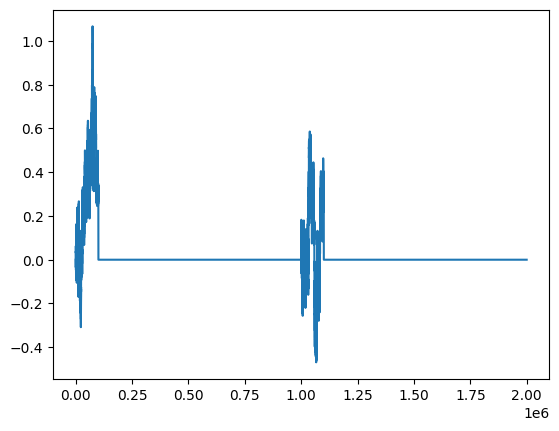

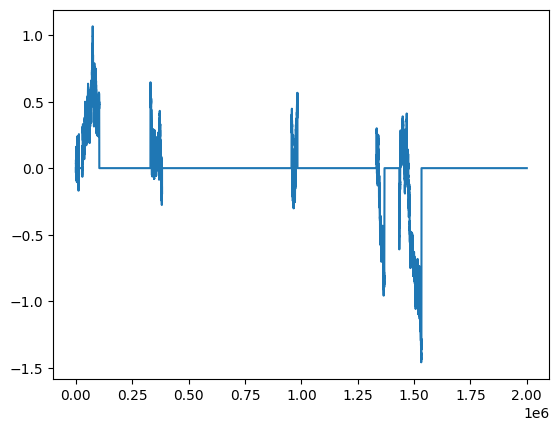

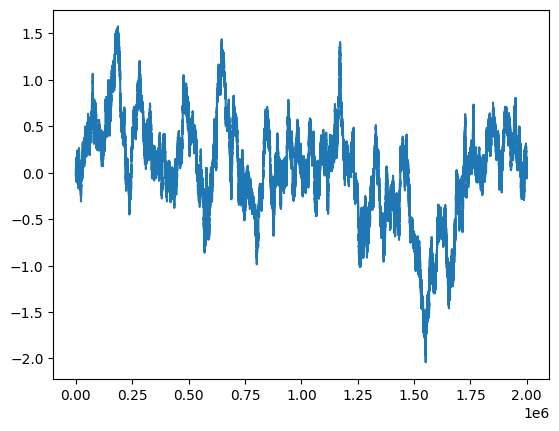

In [28]:
Wifi_output_data_after_interpolation_naive=get_sampled_channel(Wifi_naive_symbols,N)

index=0

plt.plot(Wifi_output_data_after_interpolation_naive[index]['I'])
plt.show()
plt.plot(output_samples_for_each_channel[index]['I'])
plt.show()
plt.plot(Channel_dict[index]["I"])

C:\Users\medha\AppData\Local\Temp\ipykernel_3976\3629842356.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


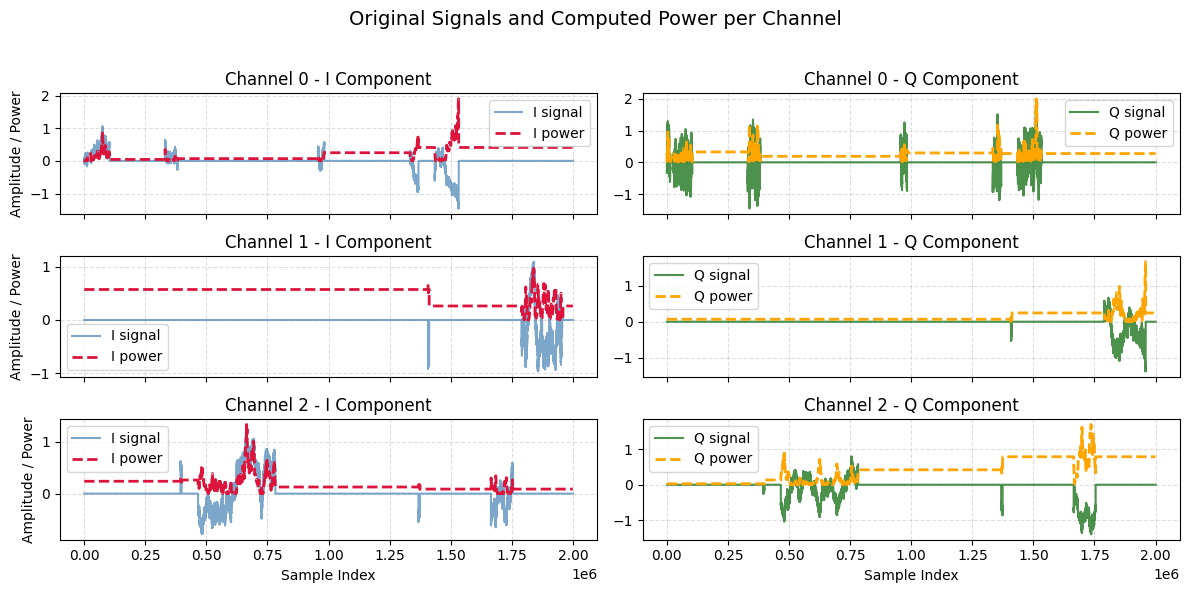

In [31]:
# plot_power_and_signals(output_samples_for_each_channel, result, num_channels)
plot_power_and_signals(output_samples_for_each_channel, result, 3)

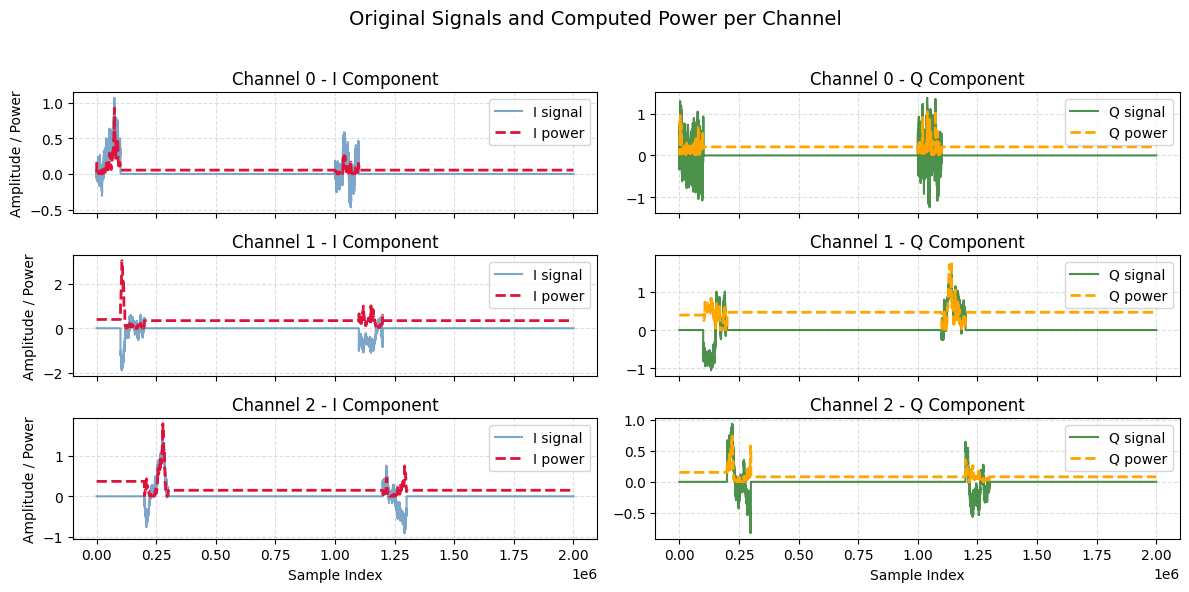

In [37]:
plot_power_and_signals(Wifi_output_data_after_interpolation_naive, result_naive, 3)

C:\Users\medha\AppData\Local\Temp\ipykernel_3976\3629842356.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


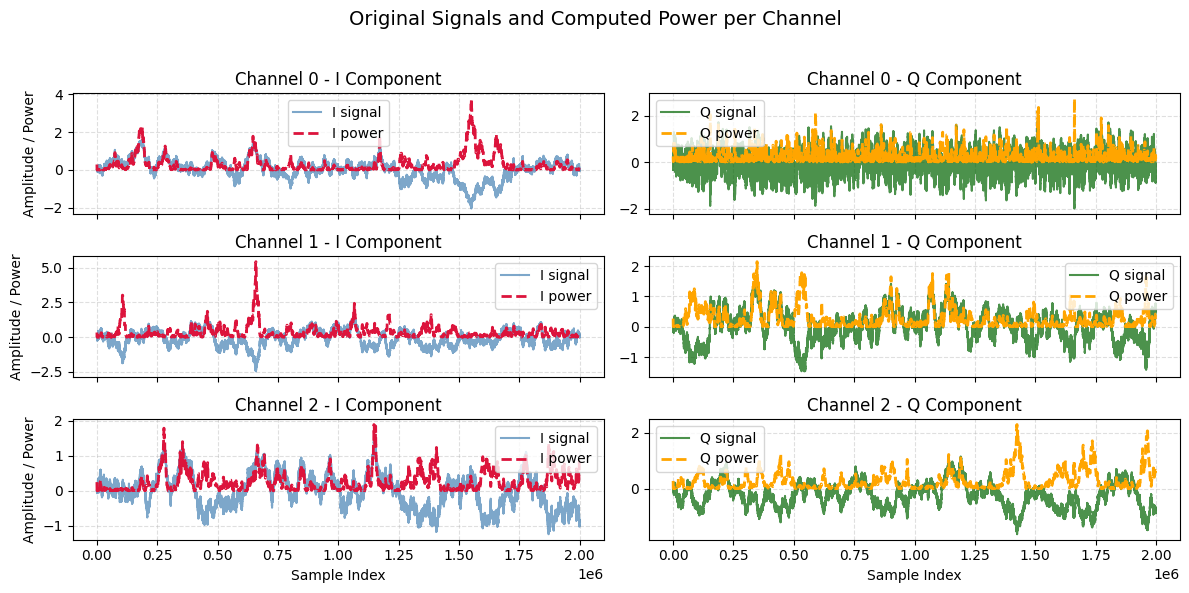

In [41]:
plot_power_and_signals(Channel_dict, result_ground_truth, 3)

In [42]:
print(result)

{0: {'I': array([0.01270033, 0.00072228, 0.00072228, ..., 0.41017982, 0.41017982,
       0.41017982]), 'Q': array([0.30915013, 0.02770535, 0.02770535, ..., 0.27609183, 0.27609183,
       0.27609183])}, 1: {'I': array([0.56998845, 0.56998845, 0.56998845, ..., 0.26171636, 0.26171636,
       0.26171636]), 'Q': array([0.06946057, 0.06946057, 0.06946057, ..., 0.24410864, 0.24410864,
       0.24410864])}, 2: {'I': array([0.2389306 , 0.2389306 , 0.2389306 , ..., 0.08761596, 0.08761596,
       0.08761596]), 'Q': array([0.02690813, 0.02690813, 0.02690813, ..., 0.78997679, 0.78997679,
       0.78997679])}, 3: {'I': array([0.00970923, 0.00970923, 0.00970923, ..., 0.30387673, 0.30387673,
       0.30387673]), 'Q': array([0.02636441, 0.02636441, 0.02636441, ..., 0.08708341, 0.08708341,
       0.08708341])}, 4: {'I': array([0.0643538 , 0.0643538 , 0.0643538 , ..., 0.13756507, 0.13756507,
       0.13756507]), 'Q': array([0.18428924, 0.18428924, 0.18428924, ..., 0.01787273, 0.01787273,
       0.0178727

In [43]:
def compute_power_differences(result, result_naive, result_ground_truth):
    """
    Compute elementwise differences of power arrays for each channel and component (I, Q)
    between result/result_naive and the ground truth.
    """
    diff_result = {}
    diff_naive = {}

    for ch in result.keys():
        diff_result[ch] = {
            'I': np.abs(result[ch]['I'] - result_ground_truth[ch]['I']),
            'Q': np.abs(result[ch]['Q'] - result_ground_truth[ch]['Q'])
        }
        diff_naive[ch] = {
            'I': np.abs(result_naive[ch]['I'] - result_ground_truth[ch]['I']),
            'Q': np.abs(result_naive[ch]['Q'] - result_ground_truth[ch]['Q'])
        }

    return diff_result, diff_naive


In [51]:
def plot_power_error_per_channel(diff_result, diff_naive, num_channels_to_plot):
    """
    Plot per-channel power errors (I and Q separately).
    Each channel gets two plots: I-error and Q-error.
    """
    fig, axs = plt.subplots(num_channels_to_plot, 2, figsize=(12, 3 * num_channels_to_plot), sharex=True)

    # Handle case where only one channel is plotted (so axs is 1D)
    if num_channels_to_plot == 1:
        axs = np.array([axs])

    for i in range(num_channels_to_plot):
    #for i in [7, 8, 9]: 
        samples = np.arange(len(diff_result[i]['I']))

        # ---- I component ----
        axs[i, 0].plot(samples, diff_result[i]['I'], label='Result vs GT', color='royalblue', linewidth=1.5)
        axs[i, 0].plot(samples, diff_naive[i]['I'], label='Naive vs GT', color='darkorange', linestyle='--', linewidth=1.5)
        axs[i, 0].set_title(f"Channel {i} - I Component Error")
        axs[i, 0].set_ylabel("Abs Power Difference")
        axs[i, 0].legend()
        axs[i, 0].grid(True, linestyle='--', alpha=0.5)

        # ---- Q component ----
        axs[i, 1].plot(samples, diff_result[i]['Q'], label='Result vs GT', color='royalblue', linewidth=1.5)
        axs[i, 1].plot(samples, diff_naive[i]['Q'], label='Naive vs GT', color='darkorange', linestyle='--', linewidth=1.5)
        axs[i, 1].set_title(f"Channel {i} - Q Component Error")
        axs[i, 1].legend()
        axs[i, 1].grid(True, linestyle='--', alpha=0.5)

    axs[-1, 0].set_xlabel("Sample Index")
    axs[-1, 1].set_xlabel("Sample Index")
    plt.suptitle("Error vs Ground Truth for Result and Naive Methods", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [ ]:
plot_power_and_signals(output_samples_for_each_channel, result, 1)

C:\Users\medha\AppData\Local\Temp\ipykernel_3976\3870407767.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


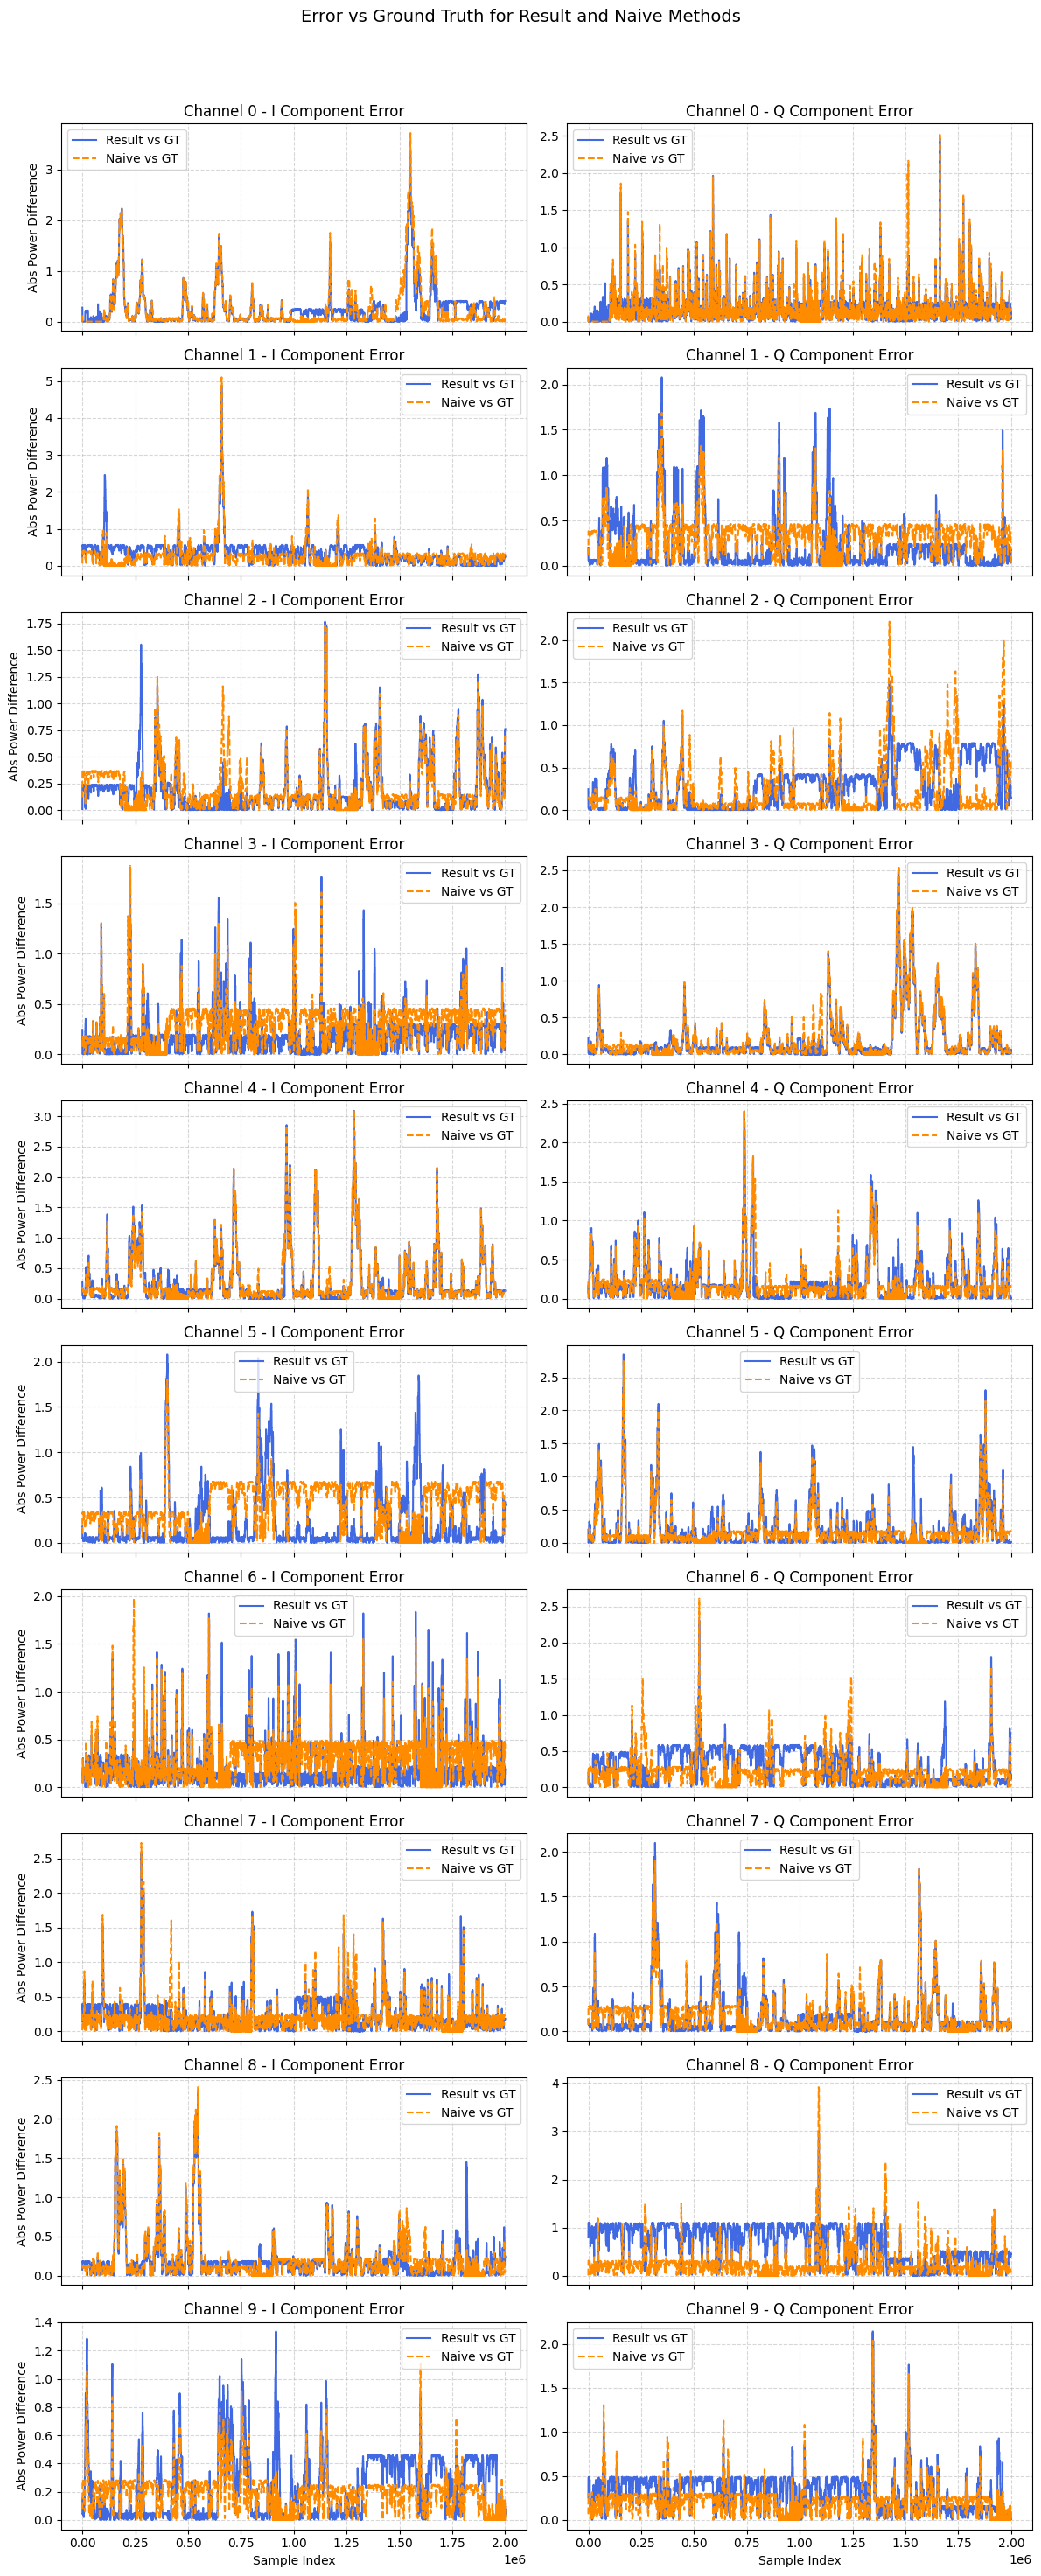

In [52]:
# Compute differences
diff_result, diff_naive = compute_power_differences(result, result_naive, result_ground_truth)

# Plot first 3 channels (or however many you want)
plot_power_error_per_channel(diff_result, diff_naive, num_channels_to_plot=10)

In [53]:
import pandas as pd

def compute_average_power_difference(diff_result, diff_naive):
    """
    Compute average absolute power difference (scalar) for each channel and component (I, Q)
    from the already-computed difference dictionaries.

    Returns a pandas DataFrame for easy display and further analysis.
    """
    data = []

    for ch in diff_result.keys():
        avg_result_I = np.mean(diff_result[ch]['I'])
        avg_result_Q = np.mean(diff_result[ch]['Q'])
        avg_naive_I = np.mean(diff_naive[ch]['I'])
        avg_naive_Q = np.mean(diff_naive[ch]['Q'])

        data.append({
            'Channel': ch,
            'Avg |I_diff| (Result vs GT)': avg_result_I,
            'Avg |Q_diff| (Result vs GT)': avg_result_Q,
            'Avg |I_diff| (Naive vs GT)': avg_naive_I,
            'Avg |Q_diff| (Naive vs GT)': avg_naive_Q
        })

    df = pd.DataFrame(data)
    return df

In [54]:
avg_diff_df = compute_average_power_difference(diff_result, diff_naive)

print("Average Absolute Power Difference per Channel:")
print(avg_diff_df)

Average Absolute Power Difference per Channel:
   Channel  Avg |I_diff| (Result vs GT)  Avg |Q_diff| (Result vs GT)  \
0        0                     0.265745                     0.194703   
1        1                     0.352785                     0.232435   
2        2                     0.184262                     0.287816   
3        3                     0.205515                     0.196019   
4        4                     0.277833                     0.209755   
5        5                     0.214332                     0.202982   
6        6                     0.210528                     0.283655   
7        7                     0.231274                     0.170933   
8        8                     0.214432                     0.677887   
9        9                     0.238714                     0.310821   

   Avg |I_diff| (Naive vs GT)  Avg |Q_diff| (Naive vs GT)  
0                    0.253658                    0.177425  
1                    0.270601           